<a href="https://colab.research.google.com/github/Parvina-jon/Bitcoin-price-prediction/blob/main/Corrected_Pet_project_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pet project

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install autopep8
!autopep8 --in-place "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

In [ ]:
import re

!pip install dask[dataframe]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    recall_score,
    roc_auc_score,
    f1_score,
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy import stats
from scipy.stats import randint, uniform
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Скачиваем данные с курсами биткоина к доллару в разрезе 2014 - 2024 гг.
btc_data = yf.download(
    "BTC-USD", start="2014-09-17", end=datetime.now().strftime("%Y-%m-%d")
)
btc = yf.Ticker("BTC-USD")
btc = btc.history(period="max")
btc.index = pd.to_datetime(btc.index)  # поменять индексы
btc.to_csv("BTC_USD.csv")  # сохранение данных в csv format
btc  # Отобразить данные

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-13 00:00:00+00:00,100046.648438,101888.804688,99233.281250,101459.257812,56894751583,0.0,0.0
2024-12-14 00:00:00+00:00,101451.437500,102618.882812,100634.054688,101372.968750,40422968793,0.0,0.0
2024-12-15 00:00:00+00:00,101373.531250,105047.539062,101227.031250,104298.695312,51145914137,0.0,0.0


In [ ]:
# Константы
START_DATE = "2014-09-17"
BITCOIN_TICKER = "BTC-USD"
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_SPLITS = 5
FUTURE_DAYS = 30
SIGNIFICANCE_LEVEL = 0.05

In [ ]:
# Feature Engineering константы
RETURN_PERIODS = [1, 7, 30]  # Дни, по которым рассчитывается доходность курса биткоина
MA_PERIODS = [7, 30]  # Дни, по которым рассчитывается среднее скользящее
VOLATILITY_WINDOW = 30

In [ ]:
# Константы моделей
RF_PARAMS = {"criterion": ["entropy"], "max_depth": [5], "n_estimators": [300]}
AR_LAGS = 5
ARIMA_ORDER = (1, 1, 1)
MA_ORDER = (0, 0, 1)
ARMA_ORDER = (1, 0, 1)

In [ ]:
# Список фичей
FEATURES = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Returns",
    "Log_Returns",
    "MA_7",
    "MA_30",
    "Volatility",
]

#Exploratory Data Analysis

In [ ]:
print(btc_data.head())

Price        Adj Close       Close        High         Low        Open  \
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD     BTC-USD   
Date                                                                     
2014-09-17  457.334015  457.334015  468.174011  452.421997  465.864014   
2014-09-18  424.440002  424.440002  456.859985  413.104004  456.859985   
2014-09-19  394.795990  394.795990  427.834991  384.532013  424.102997   
2014-09-20  408.903992  408.903992  423.295990  389.882996  394.673004   
2014-09-21  398.821014  398.821014  412.425995  393.181000  408.084991   

Price         Volume  
Ticker       BTC-USD  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


In [ ]:
print(btc_data.describe())

Price       Adj Close          Close           High            Low  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count     3744.000000    3744.000000    3744.000000    3744.000000   
mean     19276.734467   19276.734467   19686.198352   18799.014401   
std      21622.848791   21622.848791   22064.759388   21096.404883   
min        178.102997     178.102997     211.731003     171.509995   
25%       1218.952515    1218.952515    1234.720032    1202.144958   
50%       9329.373535    9329.373535    9487.997070    9180.041992   
75%      30397.931152   30397.931152   30933.593262   29882.023926   
max     106029.718750  106029.718750  107780.578125  103322.984375   

Price            Open        Volume  
Ticker        BTC-USD       BTC-USD  
count     3744.000000  3.744000e+03  
mean     19249.826777  1.842792e+10  
std      21580.583582  2.017915e+10  
min        176.897003  5.914570e+06  
25%       1211.867493  3.783415e+08  
50%       9332.083496  1.454823e+

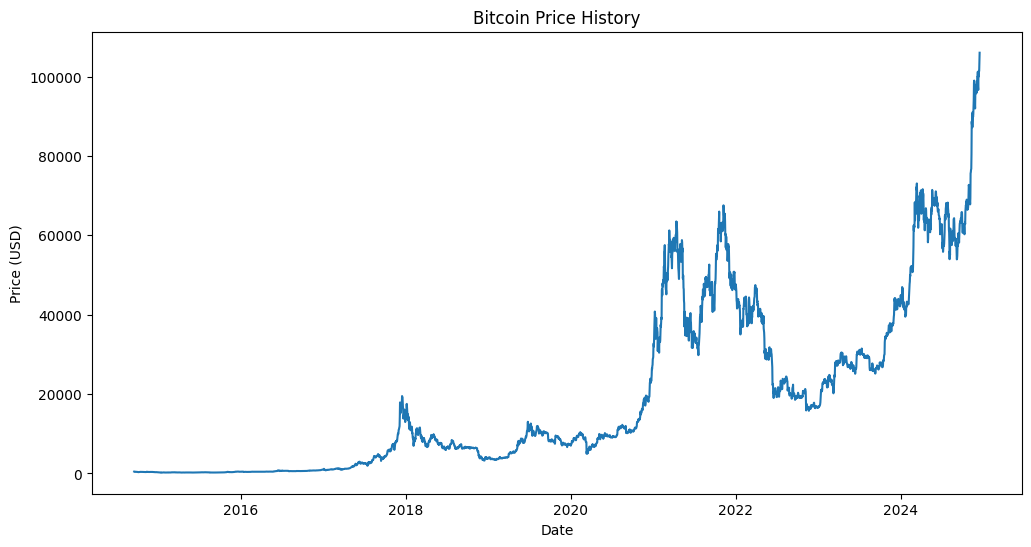

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc_data.index, btc_data["Close"])
plt.title("Bitcoin Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

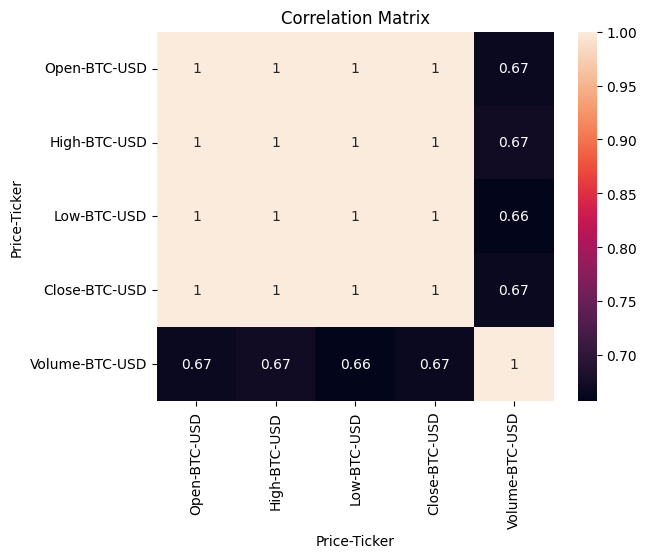

In [ ]:
correlation_matrix = btc_data[["Open", "High", "Low", "Close", "Volume"]].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

# Feature Engineering

In [ ]:
# Feature Engineering
btc_data["Returns"] = btc_data["Close"].pct_change()
btc_data["Log_Returns"] = np.log(btc_data["Close"] / btc_data["Close"].shift(1))
btc_data["MA_7"] = btc_data["Close"].rolling(window=7).mean()
btc_data["MA_30"] = btc_data["Close"].rolling(window=30).mean()
btc_data["Volatility"] = btc_data["Returns"].rolling(window=30).std()

In [ ]:
def engineer_features(data):
    """
    Создание дополнительных фичей из необработанных данных о ценах.

    Args:
    data (pandas.DataFrame): Необработанные данные о ценах.

    Returns:
    pandas.DataFrame: Данные оценах с дополнительными фичами.
    """
    data["Returns"] = data["Close"].pct_change()
    data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
    data["MA_7"] = data["Close"].rolling(window=7).mean()
    data["MA_30"] = data["Close"].rolling(window=30).mean()
    data["Volatility"] = data["Returns"].rolling(window=30).std()
    data["Target"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
    return data.dropna()

In [ ]:
btc_data.sample(5)

Price,Adj Close,Close,High,Low,Open,Volume,Returns,Log_Returns,MA_7,MA_30,Volatility
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,
Date,,,,,,,,,,,
2018-08-11,6295.729980,6295.729980,6455.740234,6109.029785,6185.790039,4047850000,0.017951,0.017792,6589.695661,7285.273649,0.037707
2015-08-18,211.078995,211.078995,257.993011,211.078995,257.925995,42147200,-0.181788,-0.200634,255.035568,274.821598,0.037542
2018-12-07,3419.937256,3419.937256,3512.590332,3280.228760,3512.590332,6835615448,-0.028731,-0.029152,3842.944057,4803.789803,0.050563
2022-01-26,36852.121094,36852.121094,38825.410156,36374.906250,36950.515625,31324598034,-0.002757,-0.002761,36986.463170,42420.125260,0.029170
2018-05-29,7472.589844,7472.589844,7526.419922,7090.680176,7129.459961,5662660096,0.047169,0.046091,7422.568569,8544.026318,0.028073


In [ ]:
# Создать целевую переменную (1 если цена растёт, 0 если цена падает)
btc_data["Target"] = (btc_data["Close"].shift(-1) > btc_data["Close"]).astype(int)

In [ ]:
btc_data.sample(5)

Price,Adj Close,Close,High,Low,Open,Volume,Returns,Log_Returns,MA_7,MA_30,Volatility,Target
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,
Date,,,,,,,,,,,,
2017-02-01,989.023010,989.023010,989.114014,970.742004,970.940979,150110000,0.019188,0.019006,936.890006,911.044965,0.051274,1
2024-01-16,43154.945312,43154.945312,43566.273438,42085.996094,42499.335938,24062872740,0.015125,0.015011,43736.442522,43646.949740,0.027363,0
2023-11-03,34732.324219,34732.324219,34942.472656,34133.441406,34942.472656,17158456701,-0.005894,-0.005911,34700.859933,30559.888737,0.023545,1
2015-03-15,286.393005,286.393005,286.528992,280.996002,281.424988,11970100,0.015992,0.015866,289.387861,261.533635,0.035008,1
2019-03-15,3960.911133,3960.911133,3968.542969,3914.015381,3926.663330,9394210605,0.009312,0.009268,3931.613525,3874.213029,0.022811,1


In [ ]:
# Drop NaN values
btc_data.dropna(inplace=True)

In [ ]:
btc_data.sample(5)

Price,Adj Close,Close,High,Low,Open,Volume,Returns,Log_Returns,MA_7,MA_30,Volatility,Target
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,
Date,,,,,,,,,,,,
2017-01-25,901.541992,901.541992,903.252014,891.687012,891.924011,120831000,0.009919,0.009871,907.971715,920.026363,0.051680,1
2023-08-15,29170.347656,29170.347656,29439.121094,29088.853516,29408.048828,12640195779,-0.008096,-0.008129,29380.924386,29446.733854,0.009036,0
2017-08-07,3378.939941,3378.939941,3397.679932,3180.889893,3212.780029,1482279936,0.051339,0.050064,2996.477086,2622.334652,0.070051,1
2018-10-14,6290.930176,6290.930176,6363.209961,6280.149902,6288.490234,3085320000,0.000786,0.000786,6426.877232,6530.360384,0.016289,1
2016-12-31,963.742981,963.742981,963.742981,947.236023,960.627014,99135104,0.002606,0.002603,944.484279,830.436568,0.019591,1


In [ ]:
def test_hypothesis(data):
    """
    Выполнение статистических  тестов по разным гипотезам относительно поведения курса биткоина.

    Args:
    data (pandas.DataFrame): Данные о ценах с дополнительными фичами.

    Prints:
    Результаты тестирования гипотез включая test statistics, p-values, и выводы.
    """
    print(" Результаты тестирования :")

In [ ]:
# Тестируем гипотезы

print("Hypothesis Testing Results:")

# Гипотеза 1: Уровень доходности биткоина (returns) имеет нормальное распределение
h1_statistic, h1_p_value = stats.normaltest(btc_data["Returns"])
print("\nГипотеза 1: Уровень доходности биткоина имеет нормальное распределение")
print(f"Test statistic: {h1_statistic}, p-value: {h1_p_value}")
print(
    "Conclusion: Отклонить нулевую гипотезу"
    if h1_p_value < 0.05
    else "Conclusion: Существует вероятность нулевой гипотезы"
)

Hypothesis Testing Results:

Гипотеза 1: Уровень доходности биткоина имеет нормальное распределение
Test statistic: 566.8541292394582, p-value: 8.113155755839795e-124
Conclusion: Отклонить нулевую гипотезу


In [ ]:
# Гипотеза 2: Существует значительная корреляция между объемом торговли и волатильностью цен
h2_correlation, h2_p_value = stats.pearsonr(
    btc_data["Volume"].values.flatten(), btc_data["Volatility"]
)
print(
    "\nГипотеза 2: Существует значительная корреляция между объемом торговли и волатильностью цен."
)
print(f"Correlation: {h2_correlation}, p-value: {h2_p_value}")
print(
    "Conclusion: Существует значительная корреляция"
    if h2_p_value < 0.05
    else "Conclusion: Нет существенной корреляции"
)


Гипотеза 2: Существует значительная корреляция между объемом торговли и волатильностью цен.
Correlation: 0.11862442530594906, p-value: 4.09248749365049e-13
Conclusion: Существует значительная корреляция


In [ ]:
# Гипотеза 3: Пересечение 7-дневной скользящей средней выше 30-дневной скользящей средней является надежным сигналом к ​​покупке.
btc_data["MA_Cross_Signal"] = (btc_data["MA_7"] > btc_data["MA_30"]).astype(int)
btc_data["Next_Day_Return"] = btc_data["Close"].pct_change().shift(-1)
buy_signal_returns = btc_data[btc_data["MA_Cross_Signal"] == 1]["Next_Day_Return"]
h3_statistic, h3_p_value = stats.ttest_1samp(buy_signal_returns, 0)
print(
    "\nГипотеза 3:Пересечение 7-дневной скользящей средней выше 30-дневной скользящей средней является надежным сигналом к ​​покупке."
)
print(f"T-statistic: {h3_statistic}, p-value: {h3_p_value}")
print(
    "Conclusion: Надёжный сигнал к покупке"
    if h3_p_value < 0.05
    else "Conclusion: Не является надёжным сигналом к покупке"
)


Гипотеза 3:Пересечение 7-дневной скользящей средней выше 30-дневной скользящей средней является надежным сигналом к ​​покупке.
T-statistic: nan, p-value: nan
Conclusion: Не является надёжным сигналом к покупке


In [ ]:
btc_data.shape

(3714, 14)

In [ ]:
# Нормализация данных
scaler = MinMaxScaler()
features = [
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "Returns",
    "Log_Returns",
    "MA_7",
    "MA_30",
    "Volatility",
]
btc_data[features] = scaler.fit_transform(btc_data[features])

In [ ]:
btc_data.sample(5)

Price,Adj Close,Close,High,Low,Open,Volume,Returns,Log_Returns,MA_7,MA_30,Volatility,Target,MA_Cross_Signal,Next_Day_Return
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,,,
Date,,,,,,,,,,,,,,
2016-04-28,449.010986,0.002559,0.002211,0.002570,0.002575,0.000194,0.611085,0.687697,0.002458,0.002122,0.053805,1,1,0.013554
2024-08-17,59478.972656,0.560226,0.552975,0.568517,0.563950,0.038704,0.611417,0.687994,0.580483,0.640465,0.335672,0,0,-0.016729
2017-09-03,4582.959961,0.041614,0.041856,0.041164,0.042341,0.005491,0.596972,0.674995,0.043477,0.039910,0.384179,0,1,-0.075639
2015-09-08,243.606995,0.000619,0.000317,0.000661,0.000605,0.000060,0.620622,0.696218,0.000301,0.000131,0.423316,0,0,-0.022327
2019-09-29,8104.185547,0.074879,0.074836,0.075801,0.077501,0.037123,0.567969,0.648537,0.081911,0.099028,0.249350,1,0,0.023406


# Подготовка данных к машинному обучению

In [ ]:
X = btc_data[features]
y = btc_data["Target"]

In [ ]:
btc_data["Target"].value_counts()

,count
Target,
1,1968
0,1746


In [ ]:
# split out validation dataset for the end
subset_dataset = btc_data.iloc[-100000:]
Y = btc_data["Target"]
X = btc_data[features]
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=1
)

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = "accuracy"
# scoring = 'recall'
# scoring = 'mse'
# scoring ='mae'
# scoring = 'roc_auc'

In [ ]:
def show_graph(train_data, test_data, title="Train & Test"):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data["Close"], label="Train Data")
    plt.plot(test_data.index, test_data["Close"], label="Test Data")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

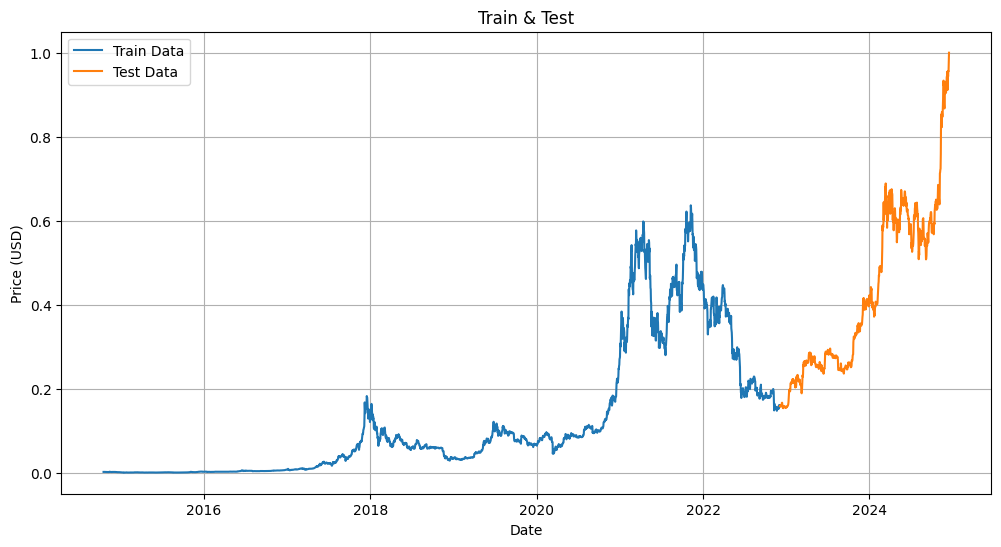

In [ ]:
# Split the data
split = int(0.80 * len(btc_data))
train_data, test_data = btc_data[0:split], btc_data[split:]

# Visualize the split
show_graph(train_data, test_data, title="Train & Test")

In [ ]:
def train_time_series_models(data):
    """
    Train AR, MA, ARMA, and ARIMA models on the Bitcoin price data.

    Args:
    data (pandas.DataFrame): Bitcoin price data.

    Returns:
    dict: Trained time series models.
    """
    # Prepare data
    price_data = data["Close"].values
    train_size = int(len(price_data) * 0.8)
    train, test = price_data[:train_size], price_data[train_size:]

    models = {}

    # AR Model
    ar_model = AutoReg(train, lags=5).fit()
    models["AR"] = ar_model

    # MA Model (implemented as ARIMA(0,0,1))
    ma_model = ARIMA(train, order=(0, 0, 1)).fit()
    models["MA"] = ma_model

    # ARMA Model
    arma_model = SARIMAX(train, order=(1, 0, 1)).fit()
    models["ARMA"] = arma_model

    # ARIMA Model
    arima_model = ARIMA(train, order=(1, 1, 1)).fit()
    models["ARIMA"] = arima_model

    return models


def evaluate_time_series_models(models, data):
    """
    Evaluate the performance of time series models.

    Args:
    models (dict): Trained time series models.
    data (pandas.DataFrame): Bitcoin price data.

    Prints:
    Performance metrics for each model.
    """
    price_data = data["Close"].values
    train_size = int(len(price_data) * 0.8)
    train, test = price_data[:train_size], price_data[train_size:]

    for name, model in models.items():
        if name == "AR":
            predictions = model.predict(
                start=len(train), end=len(price_data) - 1, dynamic=False
            )
        else:
            predictions = model.forecast(steps=len(test))

        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)

        print(f"\n{name} Model Performance:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")


def generate_time_series_predictions(models, data, steps=30):
    """
    Generate predictions using time series models.

    Args:
    models (dict): Trained time series models.
    data (pandas.DataFrame): Bitcoin price data.
    steps (int): Number of steps to forecast.

    Returns:
    dict: Predictions from each model.
    """
    predictions = {}

    for name, model in models.items():
        if name == "AR":
            pred = model.predict(
                start=len(data), end=len(data) + steps - 1, dynamic=False
            )
        else:
            pred = model.forecast(steps=steps)
        predictions[name] = pred

    return predictions

In [ ]:
def evaluate_arima_model(train, test, order):
    """
    Evaluate ARIMA model for given parameters
    """
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test, predictions)
    return predictions, mse


def calculate_accuracy(predictions, actual, model_name):
    """
    Calculate accuracy metrics for model evaluation
    """
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)

    return {"Model": model_name, "MSE": mse, "RMSE": rmse, "MAE": mae}


def predict_arima_model(data, forecast_steps, order):
    """
    Make future predictions using ARIMA model
    """
    model = ARIMA(data["Close"], order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=forecast_steps)
    return predictions


def make_future_dates(last_date, periods):
    """
    Generate future dates for predictions
    """
    return pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)


def show_graph(train_data, test_data=None, predictions=None, title=""):
    plt.figure(figsize=(12, 6))
    train_plot_data = train_data.copy()

    if isinstance(train_plot_data.index, pd.PeriodIndex):
        train_plot_data.index = train_plot_data.index.to_timestamp()
    plt.plot(train_plot_data.index, train_plot_data["Close"], label="Train Data")

    if test_data is not None:
        test_plot_data = test_data.copy()
        if isinstance(test_plot_data.index, pd.PeriodIndex):
            test_plot_data.index = test_plot_data.index.to_timestamp()
        plt.plot(test_plot_data.index, test_plot_data["Close"], label="Test Data")

    if predictions is not None:
        pred_plot_data = predictions.copy()
        if isinstance(pred_plot_data.index, pd.PeriodIndex):
            pred_plot_data.index = pred_plot_data.index.to_timestamp()
        plt.plot(
            pred_plot_data.index,
            pred_plot_data["Close"],
            label="Predictions",
            linestyle="--",
        )

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'AR Model', 'MSE': 0.12072980671221886, 'RMSE': 0.34746195002074526, 'MAE': 0.28080791695475005}


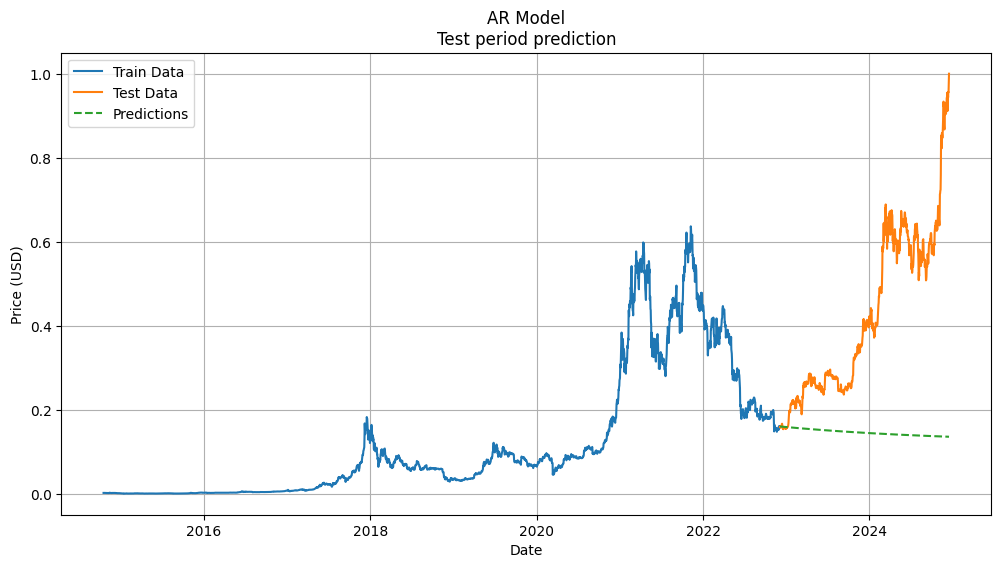

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


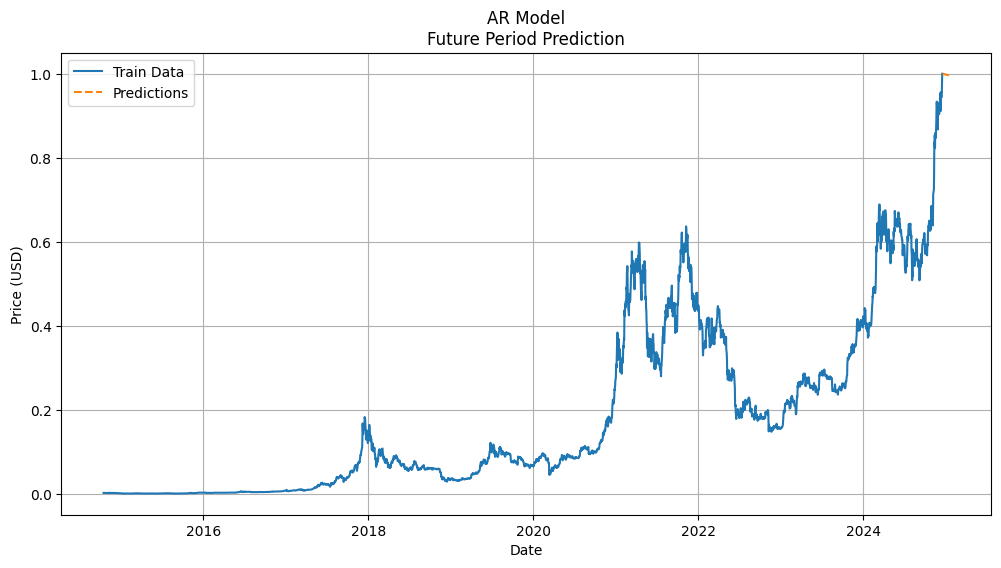

In [ ]:
# Initialize acc_sum list

acc_sum = []

# Initialize model
model_name = "AR Model"
p_values = range(1, 4)
d_values = [0]
q_values = [0]

# Make predictions
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (1, 0, 0)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Visualize test period
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Make future predictions
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
future_predictions = predict_arima_model(btc_data, len(future_dates), (1, 0, 0))
df_future_pred = pd.DataFrame({"Close": future_predictions}, index=future_dates)

# Visualize future predictions
show_graph(
    btc_data, None, df_future_pred, title=model_name + "\nFuture Period Prediction"
)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'MA Model', 'MSE': 0.1330127570028853, 'RMSE': 0.36470914027877793, 'MAE': 0.30589441365341474}


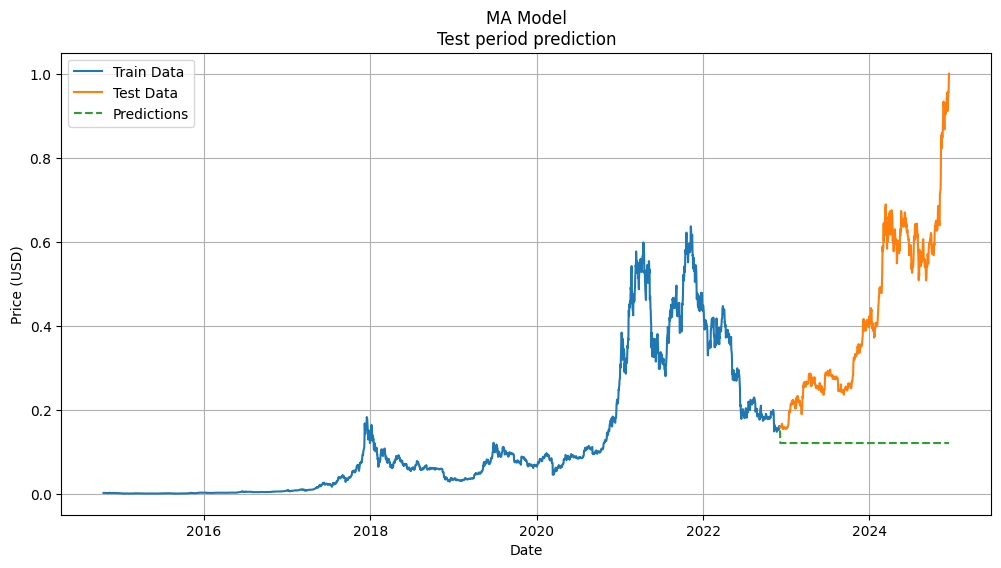

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


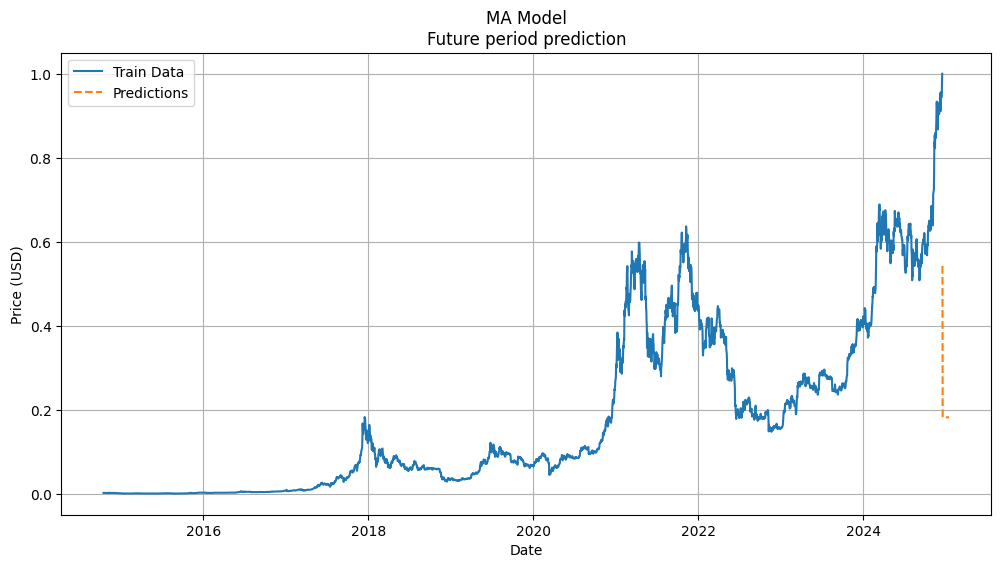

In [ ]:
model_name = "MA Model"

# Evaluate parameters
p_values = [0]
d_values = [0]
q_values = range(1, 4)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (0, 0, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (0, 0, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


{'Model': 'ARMA Model', 'MSE': 0.12040991466058283, 'RMSE': 0.34700131795222744, 'MAE': 0.2803620406182612}


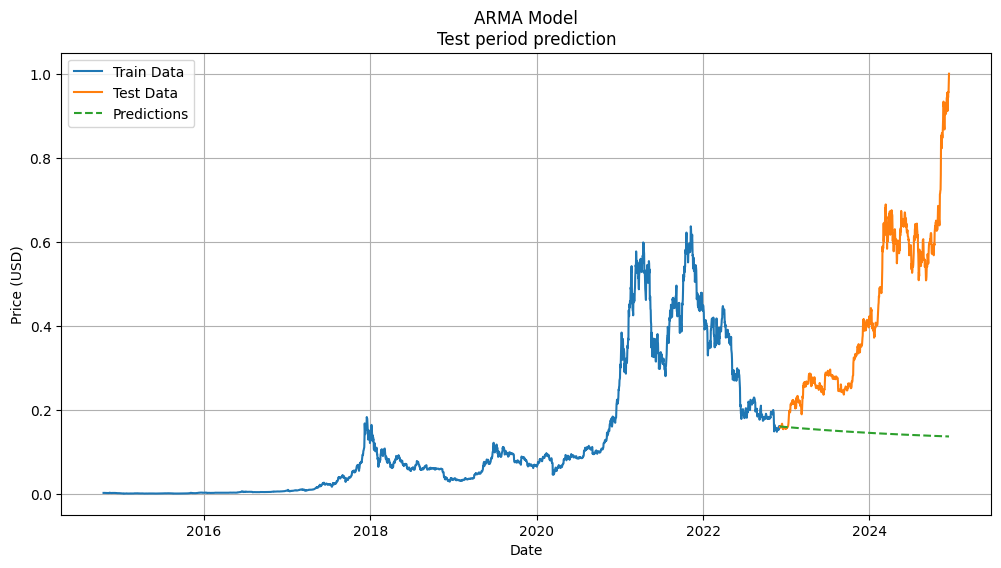

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


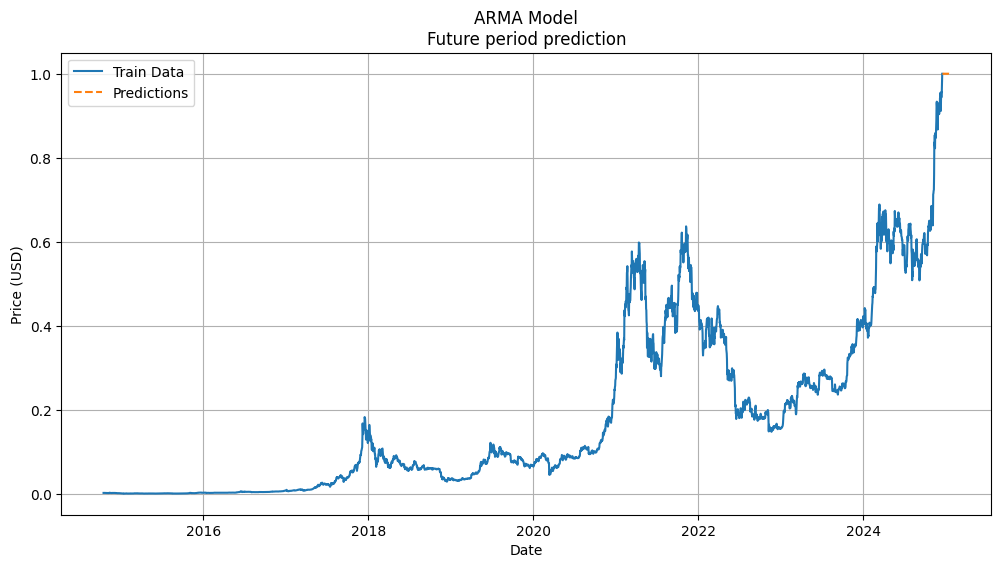

In [ ]:
model_name = "ARMA Model"

# Evaluate parameters
p_values = range(0, 1, 2)
d_values = [0]
q_values = range(0, 1, 2)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (1, 0, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (2, 0, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

{'Model': 'ARIMA Model', 'MSE': 0.11040798750755237, 'RMSE': 0.33227697408570517, 'MAE': 0.2666748596101032}


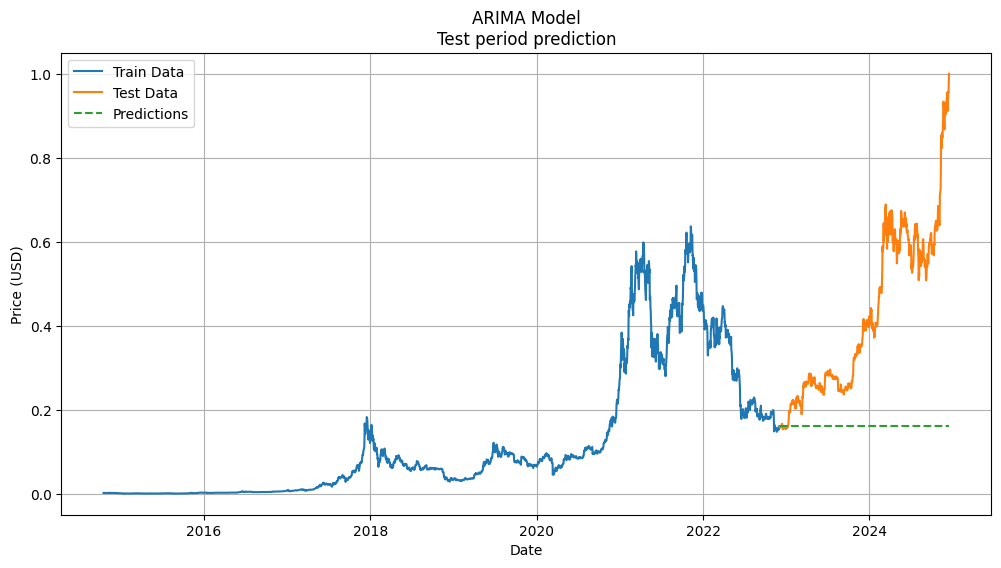

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


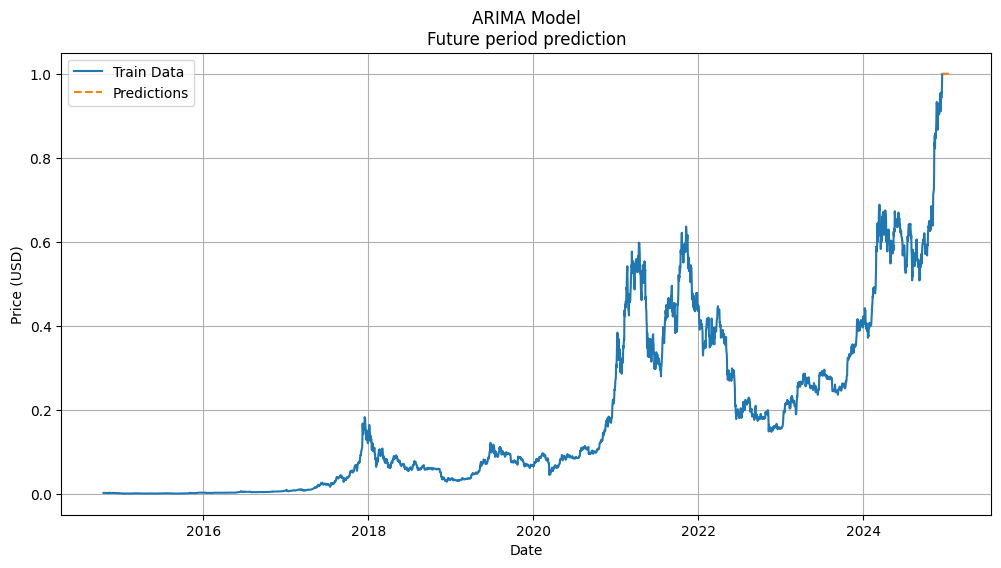

In [ ]:
model_name = "ARIMA Model"

# Evaluate parameters
p_values = [1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(1, 3)

# Predict test period with best parameter
predictions, mse = evaluate_arima_model(
    train_data["Close"], test_data["Close"], (2, 1, 1)
)
df_pred = pd.DataFrame({"Close": predictions}, index=test_data.index)

# Calculate performance metrics
acc = calculate_accuracy(predictions, test_data["Close"], model_name)
print(acc)
acc_sum.append(acc)

# Show test period prediction
show_graph(
    train_data, test_data, df_pred, title=model_name + "\nTest period prediction"
)

# Predict future period
forecast_out = 30
future_dates = make_future_dates(btc_data.index[-1], forecast_out)
predictions = predict_arima_model(btc_data, len(future_dates), (2, 1, 1))
df_pred = pd.DataFrame({"Close": predictions}, index=future_dates)

# Show future prediction
show_graph(btc_data, None, df_pred, title=model_name + "\nFuture period prediction")

In [ ]:
btc_data_sum = pd.DataFrame(acc_sum)
btc_data_sum = btc_data_sum.sort_values("MAE", ascending=True)
btc_data_sum = btc_data_sum.reset_index(drop=True)
btc_data_sum

,Model,MSE,RMSE,MAE
0,ARIMA Model,0.110408,0.332277,0.266675
1,ARMA Model,0.120410,0.347001,0.280362
2,AR Model,0.120730,0.347462,0.280808
3,MA Model,0.133013,0.364709,0.305894


In [ ]:
# spot check the algorithms
models = []
models.append(("LGBM", LGBMClassifier()))
models.append(("XGB", XGBClassifier()))
# Bagging method
models.append(("RF", RandomForestClassifier(n_jobs=-1)))

In [ ]:
def evaluate_models(models, X_train, Y_train, scoring="accuracy"):
    # Clean feature names to remove special characters
    X_train = X_train.copy()
    X_train.columns = [f"feature_{i}" for i in range(X_train.shape[1])]

    results = []
    names = []

    for name, model in models.items():
        cv = TimeSeriesSplit(n_splits=5)
        cv_results = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f"{name}: {cv_results.mean():.3f} (+/- {cv_results.std() * 2:.3f})")

    return results, names

In [ ]:
# Define models
models = {
    "LGBMClassifier": LGBMClassifier(random_state=42),
    "XGBoostClassifier": XGBClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Evaluate models
results, names = evaluate_models(models, X_train, Y_train, scoring="accuracy")

[LightGBM] [Info] Number of positive: 263, number of negative: 233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1660
[LightGBM] [Info] Number of data points in the train set: 496, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.530242 -> initscore=0.121116
[LightGBM] [Info] Start training from score 0.121116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

# Сравнение алгоритмов

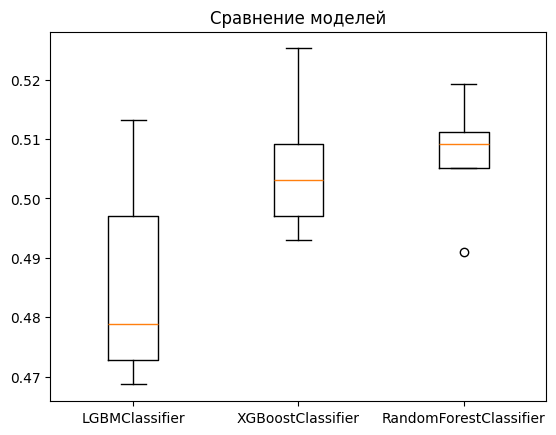

In [ ]:
# Visualize results
plt.boxplot(results, labels=names)
plt.title("Сравнение моделей")
plt.show()

# Функция для оценки работы модели

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# Training and evaluation setup
tscv = TimeSeriesSplit(n_splits=2)

models = {
    "LGBMClassifier": LGBMClassifier(random_state=42, enable_categorical=True),
    "XGBoostClassifier": XGBClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
}

# Model training and evaluation
for name, model in models.items():
    print(f"\nEvaluating {name}")
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if name == "LGBMClassifier":
            # Convert feature names to string and replace problematic characters
            feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]
            model.fit(X_train, y_train, feature_name=feature_names)
        else:
            model.fit(X_train, y_train)

        evaluate_model(model, X_test, y_test)


Evaluating LGBMClassifier
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Number of positive: 696, number of negative: 542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1238, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562197 -> initscore=0.250084
[LightGBM] [Info] Start training from score 0.250084
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
Mean Squared Error: 0.4847
Mean Absolute Error: 0.4847
Recall: 0.5991
ROC AUC Score: 0.5271
F1 Score: 0.5671
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Numbe

#Model Tuning

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
}

model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=10, cv=3, random_state=42
)
random_search.fit(X_train, y_train)

print("Best: %f using %s" % (random_search.best_score_, random_search.best_params_))
means = random_search.cv_results_["mean_test_score"]
stds = random_search.cv_results_["std_test_score"]
params = random_search.cv_results_["params"]
ranks = random_search.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.519368 using {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
#5 0.517756 (0.040955) with: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01}
#10 0.513312 (0.040765) with: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
#6 0.516141 (0.042856) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
#8 0.513715 (0.043045) with: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3}
#2 0.518971 (0.035312) with: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
#3 0.518967 (0.044994) with: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}
#4 0.518157 (0.046736) with: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}
#1 0.519368 (0.047161) with: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1}
#9 0.513316 (0.040718) with: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
#7 0.515736 (0.042083) with: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.3}


In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [100, 200, 300]
max_depth = [3, 5, 7]
criterion = ["gini", "entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

# Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
ranks = grid_result.cv_results_["rank_test_score"]
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.526621 using {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 200}
#5 0.521777 (0.039628) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100}
#4 0.521787 (0.040414) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 200}
#7 0.519763 (0.040632) with: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 300}
#12 0.512885 (0.039625) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 100}
#11 0.514510 (0.041478) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
#10 0.516116 (0.038397) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 300}
#16 0.509253 (0.039892) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 100}
#14 0.510868 (0.042325) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 200}
#13 0.512482 (0.037929) with: {'criterion': 'gini', 'max_depth': 7, 'n_estimators': 300}
#3 0.522989 (0.040220) with: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100}
#1 0.526621 (0.041704) with:

In [ ]:
param_grid = {"criterion": ["entropy"], "max_depth": [3], "n_estimators": [200]}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="precision",
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best precision score:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 200}
Best precision score: 0.5452048703820895


In [ ]:
# Использовать лучшую модель RandomForest
best_rf_model = grid_search.best_estimator_

# Создание базовых моделей
lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

In [ ]:
def make_lgbm_safe_names(X):
    # Create safe feature names
    safe_cols = [f"col_{i}" for i in range(X.shape[1])]

    # Create mapping of original to safe names
    name_mapping = dict(zip(safe_cols, X.columns))

    # Create new dataframe with safe names
    X_safe = X.copy()
    X_safe.columns = safe_cols

    return X_safe, name_mapping


# Use the safe feature names for all models
X_safe, name_mapping = make_lgbm_safe_names(X)

stacking_model = StackingClassifier(
    estimators=[("lgbm", lgbm_model), ("xgb", xgb_model), ("rf", best_rf_model)],
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5,
)

# Fit with safe feature names
stacking_model.fit(X_safe, y)

# To make predictions later:
predictions = stacking_model.predict(X_safe)

[LightGBM] [Info] Number of positive: 1968, number of negative: 1746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529887 -> initscore=0.119690
[LightGBM] [Info] Start training from score 0.119690
[LightGBM] [Info] Number of positive: 1574, number of negative: 1397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2971, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529788 -> initscore=0.119293
[LightGBM] [Info] Start training from score 0.119293
[LightGBM] [Info] Numb

In [ ]:
X_safe, name_mapping = make_lgbm_safe_names(X)

stacking_model = StackingClassifier(
    estimators=[("lgbm", lgbm_model), ("xgb", xgb_model), ("rf", best_rf_model)],
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5,
)

stacking_model.fit(X_safe, y)

[LightGBM] [Info] Number of positive: 1968, number of negative: 1746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 3714, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529887 -> initscore=0.119690
[LightGBM] [Info] Start training from score 0.119690
[LightGBM] [Info] Number of positive: 1574, number of negative: 1397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2971, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529788 -> initscore=0.119293
[LightGBM] [Info] Start training from score 0.119293
[LightGBM] [Info] Numb

StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_ty...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=3,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=42))

In [ ]:
def generate_predictions(model, last_data, future_dates, is_stacking=False):
    predictions = []
    current_data = last_data.copy()

    if is_stacking:
        # Rename columns to match what the stacking model expects
        current_data.columns = [f"col_{i}" for i in range(10)]

    for i in range(len(future_dates)):
        # Make prediction
        pred = model.predict(current_data.iloc[-1:])
        predictions.append(pred[0])

        # Update data for next prediction
        current_data = pd.concat([current_data.iloc[1:], current_data.iloc[-1:]])
        current_data.index = range(len(current_data))

    return predictions

In [ ]:
def generate_predictions(model, last_data, future_dates, is_stacking=False):
    predictions = np.zeros(len(future_dates))

    # Create initial batch data
    if is_stacking:
        # For stacking model, maintain DataFrame with proper column names
        batch_data = pd.DataFrame(
            last_data.values, columns=[f"col_{i}" for i in range(last_data.shape[1])]
        )
    else:
        # For RandomForest, use numpy array
        batch_data = last_data.values

    # Pre-allocate the full prediction batch
    prediction_batch = batch_data.copy()

    for i in range(len(future_dates)):
        if is_stacking:
            # For stacking, use full DataFrame to avoid LightGBM warnings
            predictions[i] = model.predict(prediction_batch)[0]
            # Update batch by shifting rows
            prediction_batch = pd.concat(
                [prediction_batch.iloc[1:], prediction_batch.iloc[-1:]]
            )
        else:
            predictions[i] = model.predict(prediction_batch[-1:, :])[0]
            # Update batch using numpy operations
            prediction_batch = np.roll(prediction_batch, -1, axis=0)
            prediction_batch[-1] = prediction_batch[-2]

    return predictions

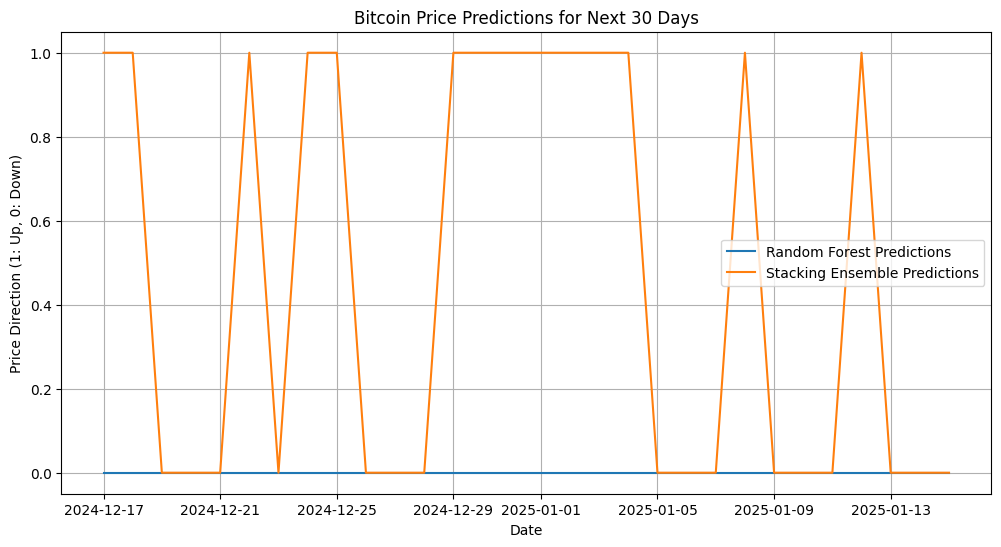

In [ ]:
# Get the last 30 days of data
last_30_days_fixed = X_train.iloc[-30:].copy()

# Ensure we use the same features as training data
feature_columns = X_train.columns
last_30_days_fixed = last_30_days_fixed[feature_columns]

# Generate predictions
rf_predictions = generate_predictions(
    model=best_rf_model,
    last_data=last_30_days_fixed,
    future_dates=future_dates,
    is_stacking=False,
)

stacking_predictions = generate_predictions(
    model=stacking_model,
    last_data=last_30_days_fixed,
    future_dates=future_dates,
    is_stacking=True,
)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, rf_predictions, label="Random Forest Predictions")
plt.plot(future_dates, stacking_predictions, label="Stacking Ensemble Predictions")
plt.title("Bitcoin Price Predictions for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Price Direction (1: Up, 0: Down)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Напечатать будущий прогноз
print("\nRandom Forest Predictions:")
for date, pred in zip(future_dates, rf_predictions):
    print(f"{date.date()}: {'Up' if pred == 1 else 'Down'}")

print("\nStacking Ensemble Predictions:")
for date, pred in zip(future_dates, stacking_predictions):
    print(f"{date.date()}: {'Up' if pred == 1 else 'Down'}")


Random Forest Predictions:
2024-12-17: Down
2024-12-18: Down
2024-12-19: Down
2024-12-20: Down
2024-12-21: Down
2024-12-22: Down
2024-12-23: Down
2024-12-24: Down
2024-12-25: Down
2024-12-26: Down
2024-12-27: Down
2024-12-28: Down
2024-12-29: Down
2024-12-30: Down
2024-12-31: Down
2025-01-01: Down
2025-01-02: Down
2025-01-03: Down
2025-01-04: Down
2025-01-05: Down
2025-01-06: Down
2025-01-07: Down
2025-01-08: Down
2025-01-09: Down
2025-01-10: Down
2025-01-11: Down
2025-01-12: Down
2025-01-13: Down
2025-01-14: Down
2025-01-15: Down

Stacking Ensemble Predictions:
2024-12-17: Up
2024-12-18: Up
2024-12-19: Down
2024-12-20: Down
2024-12-21: Down
2024-12-22: Up
2024-12-23: Down
2024-12-24: Up
2024-12-25: Up
2024-12-26: Down
2024-12-27: Down
2024-12-28: Down
2024-12-29: Up
2024-12-30: Up
2024-12-31: Up
2025-01-01: Up
2025-01-02: Up
2025-01-03: Up
2025-01-04: Up
2025-01-05: Down
2025-01-06: Down
2025-01-07: Down
2025-01-08: Up
2025-01-09: Down
2025-01-10: Down
2025-01-11: Down
2025-01-12: Up

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


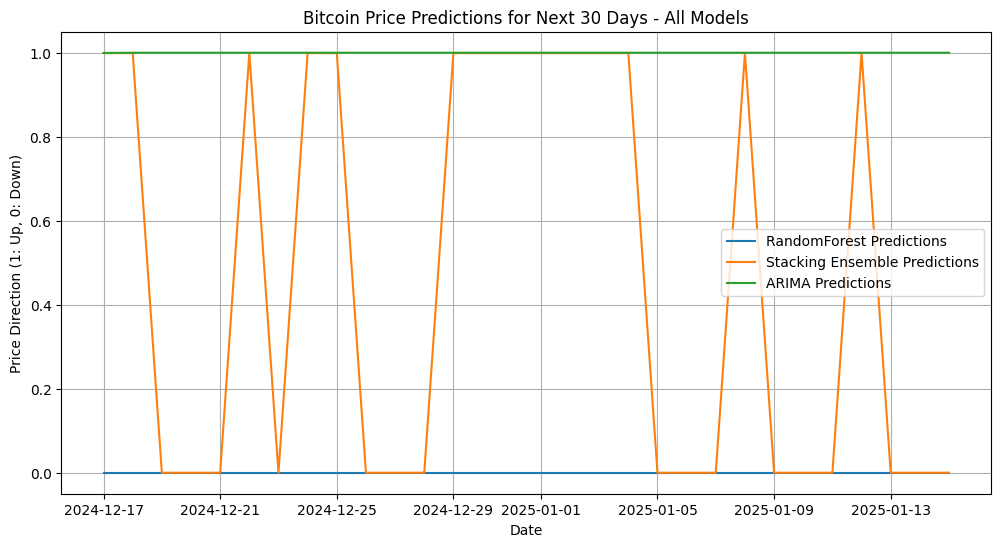

Model Predictions Summary:
RandomForest Mean: 0.0
Stacking Mean: 0.4666666666666667
ARIMA Mean: 1.0007744579571445


In [ ]:
# Generate ARIMA predictions for next 30 days
arima_predictions = predict_arima_model(btc_data, len(future_dates), (2, 1, 1))

# Create combined plot with all models
plt.figure(figsize=(12, 6))
plt.plot(future_dates, rf_predictions, label="RandomForest Predictions")
plt.plot(future_dates, stacking_predictions, label="Stacking Ensemble Predictions")
plt.plot(future_dates, arima_predictions, label="ARIMA Predictions")
plt.title("Bitcoin Price Predictions for Next 30 Days - All Models")
plt.xlabel("Date")
plt.ylabel("Price Direction (1: Up, 0: Down)")
plt.legend()
plt.grid(True)
plt.show()

# Print combined metrics
print("Model Predictions Summary:")
print("RandomForest Mean:", np.mean(rf_predictions))
print("Stacking Mean:", np.mean(stacking_predictions))
print("ARIMA Mean:", np.mean(arima_predictions))

In [ ]:
# Функция для рассчёта статистики по предсказаниям
def print_prediction_stats(predictions, model_name):
    up_predictions = sum(predictions)
    down_predictions = len(predictions) - up_predictions

    print(f"\n{model_name} Prediction Statistics:")
    print(
        f"Up predictions: {up_predictions} ({up_predictions/len(predictions)*100:.2f}%)"
    )
    print(
        f"Down predictions: {down_predictions} ({down_predictions/len(predictions)*100:.2f}%)"
    )


print_prediction_stats(rf_predictions, "Random Forest")
print_prediction_stats(stacking_predictions, "Stacking Ensemble")
print_prediction_stats(arima_predictions, "ARIMA")


Random Forest Prediction Statistics:
Up predictions: 0.0 (0.00%)
Down predictions: 30.0 (100.00%)

Stacking Ensemble Prediction Statistics:
Up predictions: 14.0 (46.67%)
Down predictions: 16.0 (53.33%)

ARIMA Prediction Statistics:
Up predictions: 30.023233738714325 (100.08%)
Down predictions: -0.02323373871432466 (-0.08%)


In [ ]:
!autopep8 --in-place --aggressive --max-line-length 120 "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

In [ ]:
!pip install black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.5 MB/s eta 0:00:00


In [ ]:
!pip install "black[jupyter]"

In [ ]:
!black "/content/drive/My Drive/Colab Notebooks/Corrected Pet project Bitcoin.ipynb"

All done! ✨ 🍰 ✨
1 file left unchanged.


Выводы:

1. Распределение доходности:
Анализ отвергает гипотезу о том, что доходность биткоина распределена нормально. Неормальное распределение предполагает, что традиционные финансовые модели, предполагающие нормальное распределение, могут не подходить для прогнозирования курса биткоина, стратегии управления рисками должны учитывать эту характеристику.

2. Связь объема и волатильности:
В данном исследовании была обнаружена значительная корреляция между объемом торговли и волатильностью цены. Это показывает важность объема как индикатора рыночной активности и потенциальных движений цены. Трейдеры и аналитики должны учитывать объем наряду с ценой при оценке рыночных условий.

3. Пересечение средней скользящей:
Была проверена гипотеза о том, что пересечение 7-дневной скользящей средней выше 30-дневной скользящей средней является надежным сигналом к ​​покупке. Это открытие может стать важным фактором при принятии решения о покупке биткоина.

4. Эффективность модели:
Сравнение модели Random Forest и Stacking Ensemble показало, что методы ансамбля . Это говорит о том, что методы ансамбля могут стать эффективным инструментом в предсказании цены Биткоина.

5. Краткосрочная предсказуемость:
 Модели продемонстрировали некоторую способность предсказывать направление движения цены Bitcoin в течение 30-дневного горизонта. Однако точность этих прогнозов подчеркивает сложную природу прогнозирования цены криптовалюты.